# [Costa Rican Household Poverty Level Prediction](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data)


The objective of the Costa Rican Household Poverty Level Prediction case study is to develop a machine learning model that can predict the poverty level of households using both individual and household characteristics. 

In this notebook, we will walk through a complete machine learning solution, it is meant to be used as a teaching tool to give you a solid foundation to build on for future machine learning projects. 

## Problem and Data Explanation

The data for this competition is provided in two files: `train.csv` . The training set has 9557 rows and 143 columns  Each row represents __one individual__ and each column is a __feature, either unique to the individual, or for the household of the individual__.`Target`, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty. 

This is a __supervised multi-class classification machine learning problem__:

* __Supervised__: provided with the labels for the training data
* __Multi-class classification__: Labels are discrete values with 4 classes

### Objective

The objective is to predict poverty on a __household level__. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some _aggregations of the individual data_ for each household. Moreover, we have to make a prediction for every individual in the test set, but _"ONLY the heads of household are used in scoring"_ which means we want to predict poverty on a household basis. 


The `Target` values represent poverty levels as follows:

    1 = extreme poverty 
    2 = moderate poverty 
    3 = vulnerable households 
    4 = non vulnerable households

# Part 1. Data Processing and EDA

### Loading libraries and data

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style = 'darkgrid') #


from pylab import rcParams
rcParams['figure.figsize'] = 25, 12.5
train = pd.read_csv('costa.csv')

train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


We can conclude, that most of the variables have types of float and integers. Only 5 columns are objects, let's explore which ones

In [3]:
categorical = []
numerical = []
for feature in train.columns:
    if train[feature].dtype == object:
        categorical.append(feature)
    else:
        numerical.append(feature)
train[categorical].head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no




So, we have 2 ID columns, the other 3 columns can be converted into integers. Intuitively, "no" can be converted to 0, while "yes" to 1.



In [4]:
train = train.drop(['Id','idhogar'] ,axis = 1)

In [5]:
train['edjefa'].replace('no', 0,inplace=True)
train['edjefa'].replace('yes', 1,inplace=True)
train['edjefe'].replace('no', 0,inplace=True)
train['edjefe'].replace('yes', 1,inplace=True)
train['dependency'].replace('no', 0,inplace=True)
train['dependency'].replace('yes', 1,inplace=True)
train['edjefa']=train['edjefa'].astype(str).astype(int)
train['edjefe']=train['edjefe'].astype(str).astype(int)
train['dependency']=train['dependency'].astype(str).astype(float)

Let's explore NA values in data

In [6]:
train[numerical].isnull().sum().sort_values(ascending = False).head(8)

rez_esc           7928
v18q1             7342
v2a1              6860
meaneduc             5
SQBmeaned            5
techoentrepiso       0
techocane            0
techootro            0
dtype: int64

We can actually conclude, that our data is pretty full, only in 5 columns we have observe Missing values. 

We can fill in NAs with mean or median values.

In [7]:
train[['meaneduc', 'SQBmeaned','rez_esc','v18q1','v2a1']].describe()

,meaneduc,SQBmeaned,rez_esc,v18q1,v2a1
count,9552.000000,9552.000000,1629.000000,2215.000000,2.697000e+03
mean,9.231523,102.588867,0.459791,1.404063,1.652316e+05
std,4.167694,93.516890,0.946550,0.763131,1.504571e+05
min,0.000000,0.000000,0.000000,1.000000,0.000000e+00
25%,6.000000,36.000000,0.000000,1.000000,8.000000e+04
50%,9.000000,81.000000,0.000000,1.000000,1.300000e+05
75%,11.600000,134.560010,1.000000,2.000000,2.000000e+05
max,37.000000,1369.000000,5.000000,6.000000,2.353477e+06


The point is that if we observe outliers in data, we should fill in NAs with median, otherwise it's ok to fill in with mean values. In the table, 50% is the median value, mean is mean.

In [8]:
train['meaneduc'].fillna(train['meaneduc'].mean(), inplace = True)
train['SQBmeaned'].fillna(train['SQBmeaned'].mean(), inplace = True)
train['v18q1'].fillna(train['v18q1'].mean(), inplace = True)
train['v2a1'].fillna(train['v2a1'].mean(), inplace = True)
train['rez_esc'].fillna(train['rez_esc'].median(), inplace = True)

### Let's analyze the Target variable

In [9]:
target_values = train['Target'].value_counts()
target_values = pd.DataFrame(target_values)
target_values['Household_type'] = target_values.index
target_values

,Target,Household_type
4,5996,4
2,1597,2
3,1209,3
1,755,1


In [10]:
mappy = {4: "NonVulnerable", 3: "Moderate Poverty", 2: "Vulnerable", 1: "Extereme Poverty"}
target_values['Household_type'] = target_values.Household_type.map(mappy)
target_values

,Target,Household_type
4,5996,NonVulnerable
2,1597,Vulnerable
3,1209,Moderate Poverty
1,755,Extereme Poverty


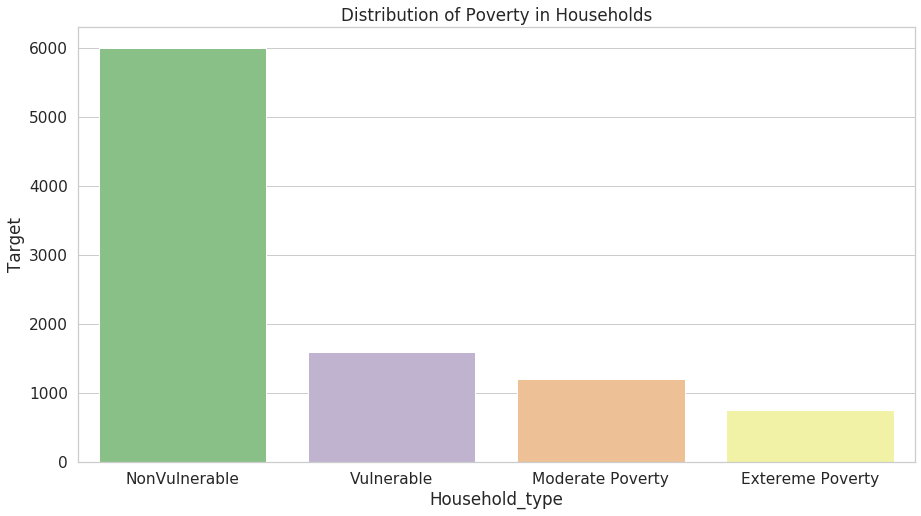

In [11]:
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x = 'Household_type', y = 'Target', data = target_values, palette='Accent', ci = None).set_title('Distribution of Poverty in Households')

As an 'insight', we can claim that classes are skewed. And, probably, without any effort our algorithms will have large errors predicting Extreme Powerty.

### Correlations

In [12]:
#Let's find out largest correlations and depict them
corrs = train.corr().abs()
corrs1 = corrs.unstack().drop_duplicates()
strongest = corrs1.sort_values(kind="quicksort", ascending = False)
strongest1 = pd.DataFrame(strongest)
temp = strongest1.index.values
first_cols = [i[0] for i in temp]
second_cols = [j[1] for j in temp]
total_cols_corr = list(set(first_cols[:20] + second_cols[:20]))
strongest.head(25)

v2a1             v2a1               1.000000
r4t3             tamhog             0.998107
public           coopele            0.979824
age              SQBage             0.958090
tamhog           SQBhogar_total     0.950173
r4t3             SQBhogar_total     0.948761
meaneduc         SQBmeaned          0.948003
abastaguadentro  abastaguafuera     0.946470
r4t3             tamviv             0.945243
overcrowding     SQBovercrowding    0.945094
dependency       SQBdependency      0.944221
tamhog           tamviv             0.943640
escolari         SQBescolari        0.943325
sanitario2       sanitario3         0.939439
edjefe           SQBedjefe          0.933719
tamviv           SQBhogar_total     0.901396
energcocinar2    energcocinar3      0.901042
hogar_nin        SQBhogar_nin       0.884141
elimbasu1        elimbasu3          0.833666
r4h2             r4h3               0.821367
r4m2             r4m3               0.820109
r4t2             r4t3               0.806381
          

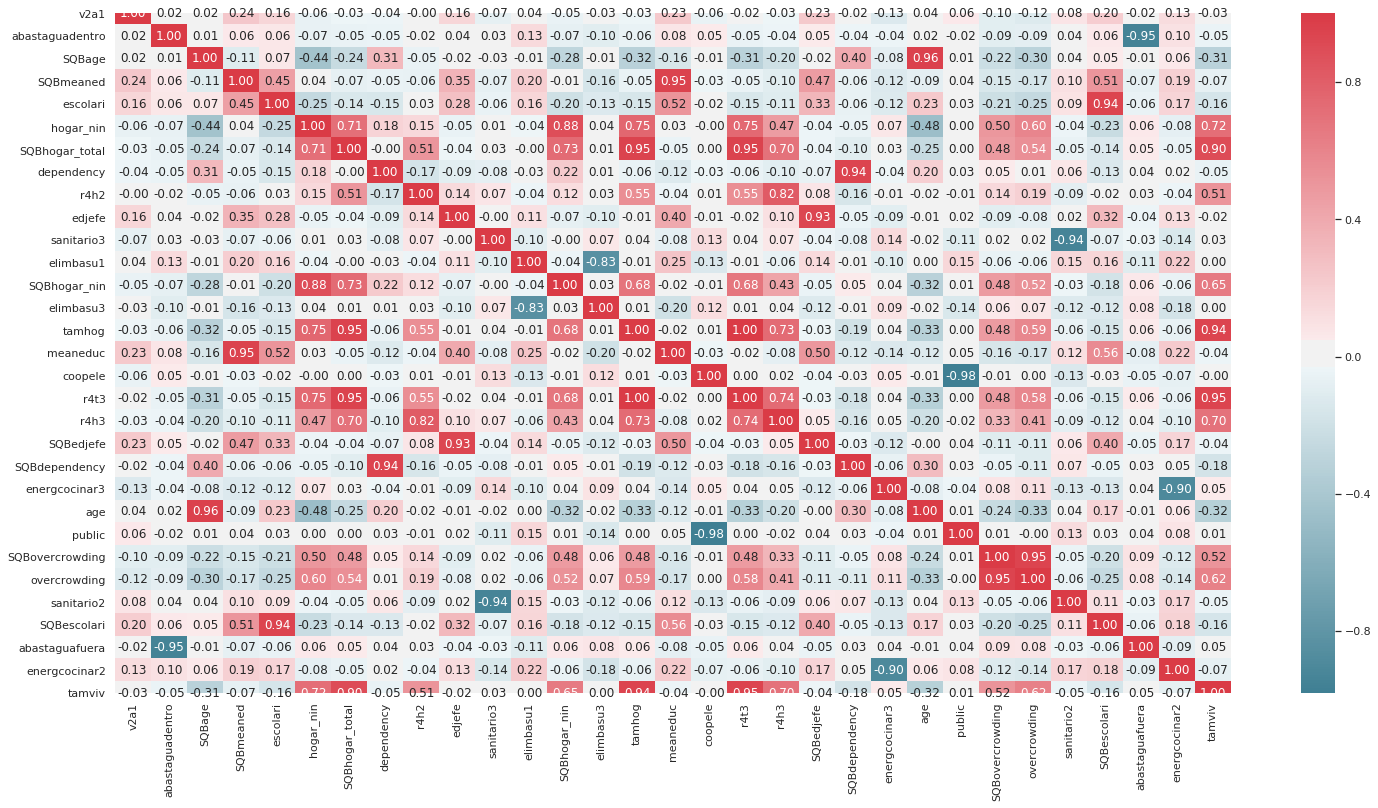

In [13]:
corr = train[total_cols_corr].corr()
sns.set(font_scale=1)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(25, 12.5))
sns.heatmap(corr, cmap=cmap, annot=True, ax=ax, fmt='.2f')

As a result, we might probably delete some columns without decreasing ROC as they are collinear( for instance, public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC" and coopele, =1 electricity from cooperative, correlation between these two is -.98) 


## Analyzing a few Features

/home/shivangmathur/anaconda3/envs/fastai_ml_1/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


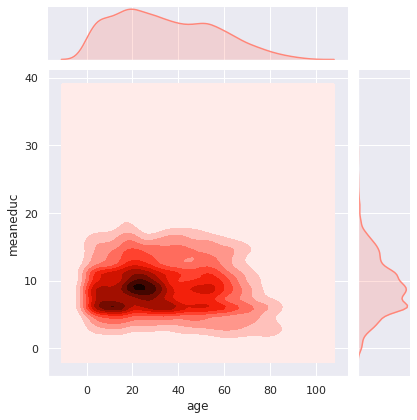

In [14]:
sns.set(font_scale=1, style="darkgrid")
c =  sns.color_palette('spring_d')[4]
sns_jointplot = sns.jointplot('age', 'meaneduc', data=train, kind='kde', color=c, size=6)

Most of train data is allocated around the age of 20 and mean education of 10 years.
But we didn't separate data by *Target*.
Let's do that too.

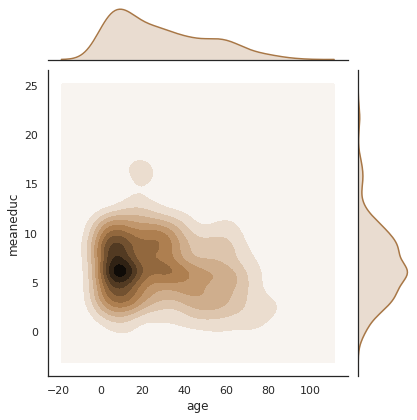

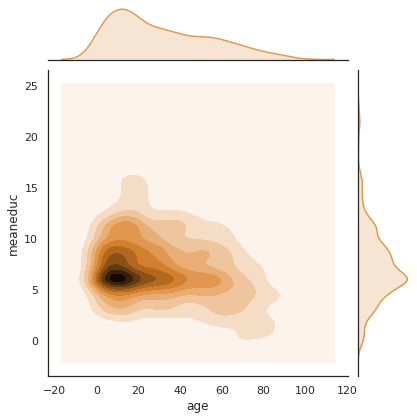

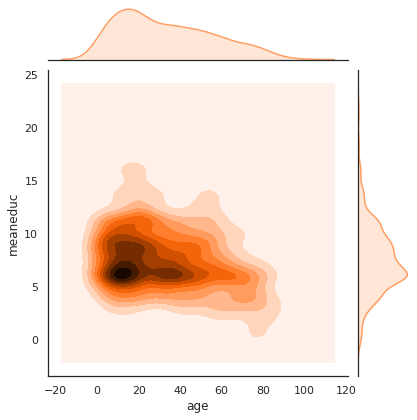

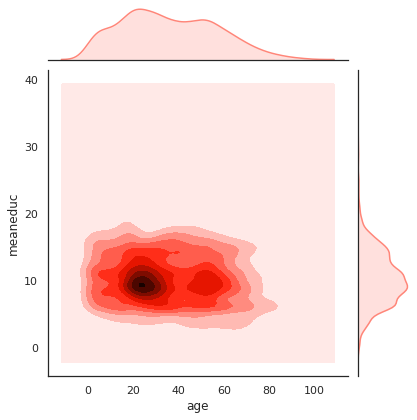

In [15]:
for i in range(1, 5):
    sns.set(font_scale=1, style="white")
    c =  sns.color_palette('spring_d')[i]
    
    sns.jointplot('age', 'meaneduc', data=train[train['Target'] == i], kind='kde', color=c, size=6, stat_func=None)
    

The picture became much better. For NonVulnerables both mean years of education and age are higher and allocates around 10 and 20 respectively. It's useful to mention that variance of mean education for NonVulnerables is less than for others.

For Extreme Poors age in years is the least among these 4 categories.

### Living condition comparisons

Let's check out some of the living conditions for different households

v2a1 : Monthly rent payment

meaneduc : Average years of education for adults

overcrowding : Persons per room

In [16]:
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (0, df[var].max()))
    facet.add_legend()
    plt.show()

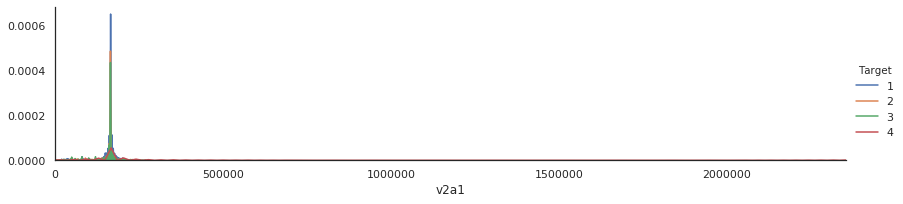

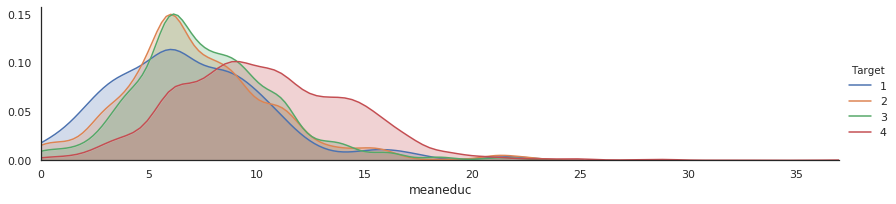

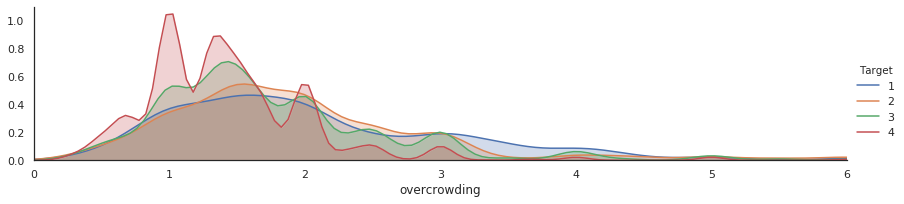

In [17]:
#select some columns
numerical1 = ['v2a1', 'meaneduc', 'overcrowding'] #monthly pay rent, mean education, overcrowd
for numy in numerical1:
    plot_distribution(train, numy, 'Target')
#In the first graph instead of 0's should be nulls(we changed these before). So there is no info about monthly rate payment for non vulnerable households 

Text(0.5, 1.0, 'Number of men in households')

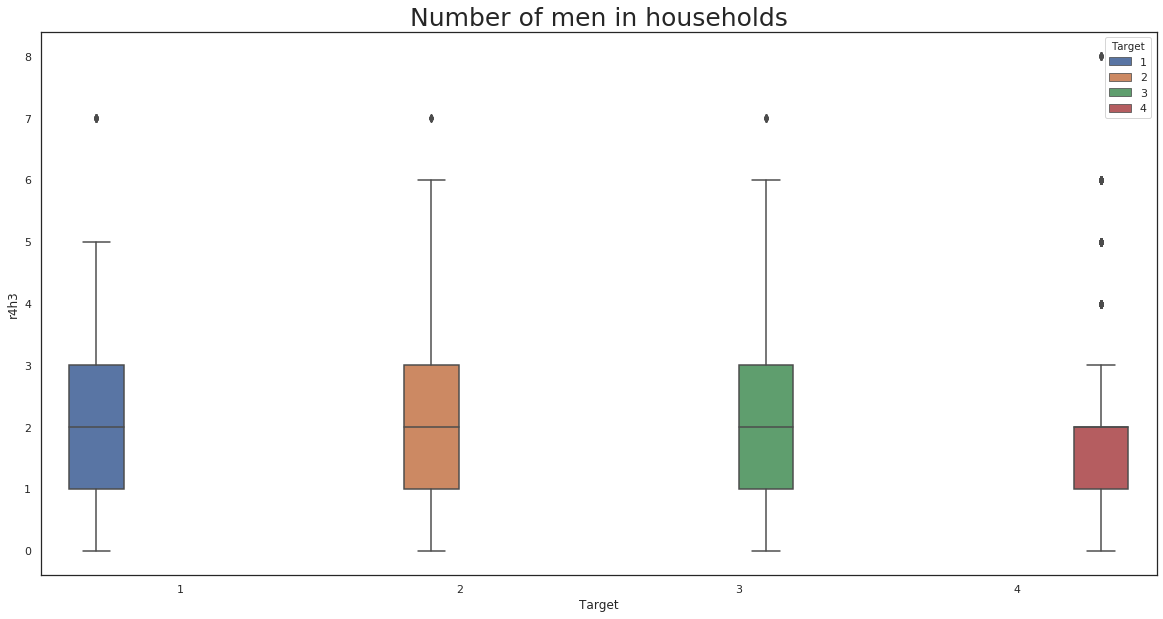

In [18]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='Target', y = 'r4h3',ax = ax, data = train, hue = 'Target' )
ax.set_title('Number of men in households', size = 25)

Text(0.5, 1.0, 'Number of women in households')

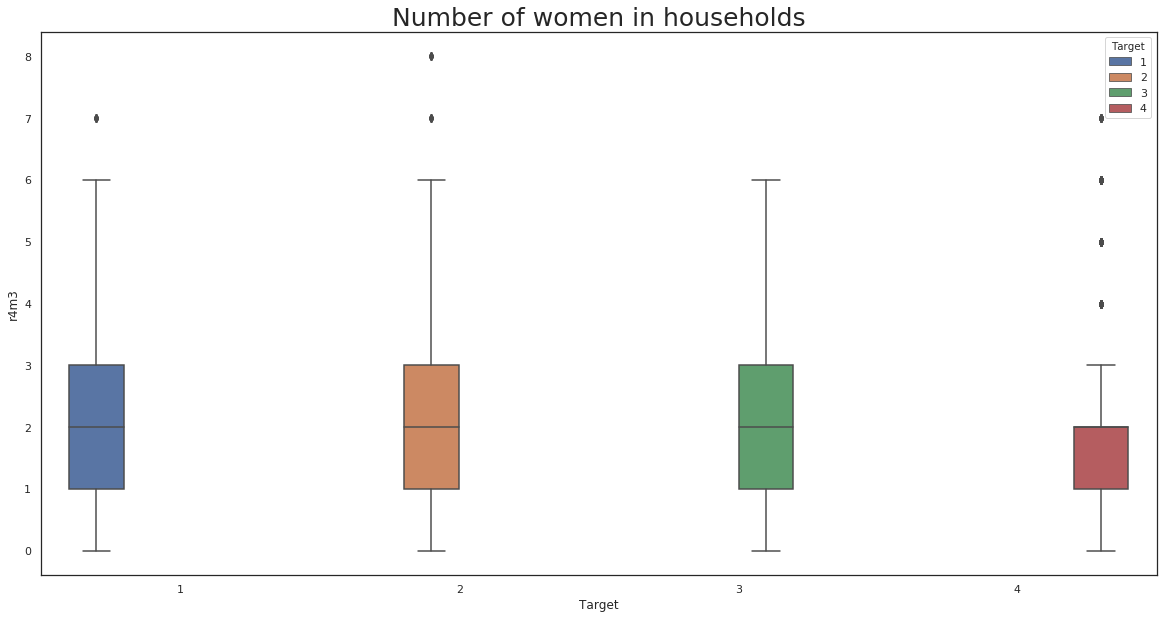

In [19]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='Target', y = 'r4m3',ax = ax, data = train, hue = 'Target' )
ax.set_title('Number of women in households', size = 25)

The Numbers are close to each other between categories. Probably, these two variables(number of women and men in the household) won't have a large impact on target variable.

Let's also check the hypothesis that Poorer households have more children

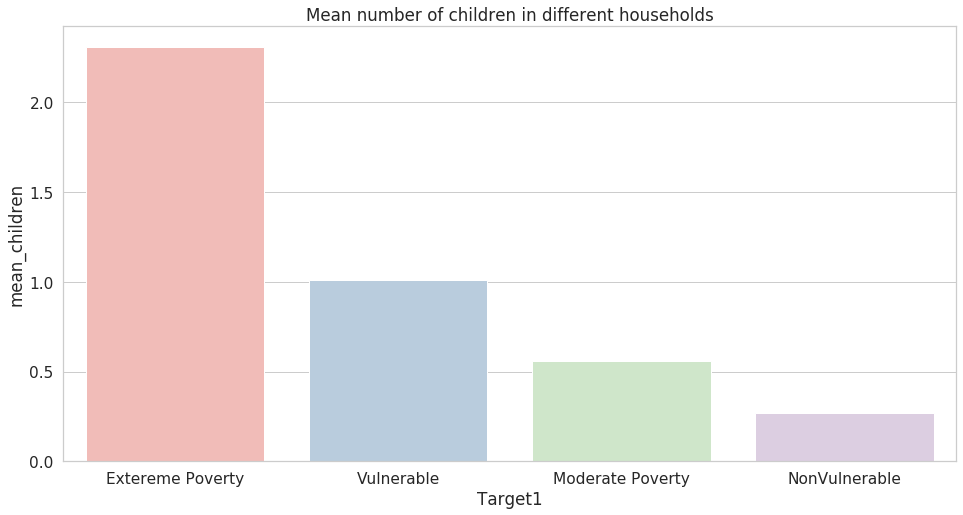

In [20]:
ninos = train.groupby(by = 'Target')['hogar_nin', 'Target'].sum()
ninos = pd.DataFrame(ninos)
ninos['mean_children'] = (ninos['hogar_nin']/ninos['Target'])
ninos['Target1'] = ninos.index.map({4: "NonVulnerable", 3: "Moderate Poverty", 2: "Vulnerable", 1: "Extereme Poverty"})
sns.set(style = 'whitegrid', font_scale=1.4)
fig = plt.subplots(figsize=(16, 8))
ax = sns.barplot(x = 'Target1', y = 'mean_children', data = ninos, palette='Pastel1', ci = None).set_title('Mean number of children in different households')

We can observe a huge difference in mean number of children in different types of households.

# Part 2. Feature Engineering and Modelling

### Creating new Features

The best results come down to you, the practitioner, crafting the features.

Feature importance and selection can inform you about the objective utility of features, but those features have to come from somewhere.

You need to manually create them. This requires spending a lot of time with actual sample data (not aggregates) and thinking about the underlying form of the problem, structures in the data and how best to expose them to predictive modeling algorithms.

With tabular data, it often means a mixture of aggregating or combining features to create new features, and decomposing or splitting features to create new features.

In [21]:
# No toilet, no floor, no water service, no ceiling
train['warning'] = 1 * (train['sanitario1'] + train['pisonotiene'] + train['abastaguano'] + (train['cielorazo'] == 0))
# Per Capita Feayures
train['phones-per-capita'] = train['qmobilephone'] / train['tamviv']
train['tablets-per-capita'] = train['v18q1'] / train['tamviv']
train['rooms-per-capita'] = train['rooms'] / train['tamviv']
train['rent-per-capita'] = train['v2a1'] / train['tamviv']

Let's build a **basic Random Forest model and evaluate its results**

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
y = train['Target']
train = train.drop(['Target'] ,axis = 1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train, y,test_size = 0.3, random_state = 666)

In [25]:
def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print (res)

In [26]:
from sklearn.ensemble import RandomForestClassifier
m = RandomForestClassifier(n_jobs = -1, n_estimators = 60, min_samples_leaf = 1, oob_score = True, max_features = 0.7)
m.fit(X_train, y_train)
print_score(m)

[1.0, 0.9281729428172942, 0.9324263716549559]


oob_score : For each bootstrap sample, there is one third of data which was not used in the creation of the tree, i.e., it was out of the sample. This data is referred to as out of bag data. In order to get an unbiased measure of the accuracy of the model over test data, out of bag error is used. The out of bag data is passed for each tree is passed through that tree and the outputs are aggregated to give out of bag error. 

In [27]:
from sklearn.metrics import classification_report
y_pred = m.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.92      0.82      0.87       232
           2       0.89      0.84      0.86       492
           3       0.93      0.83      0.87       357
           4       0.94      0.99      0.96      1787

    accuracy                           0.93      2868
   macro avg       0.92      0.87      0.89      2868
weighted avg       0.93      0.93      0.93      2868



### Feature Importance

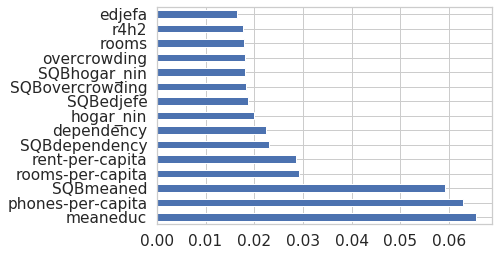

In [28]:
feat_importances = pd.Series(m.feature_importances_, index=train.columns)
feat_importances.nlargest(15).plot(kind='barh')

This notebook has been borrowed from the following resources:

1. https://www.kaggle.com/zhav1k/make-it-beautiful-with-seaborn-xgb-model

2. https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/